<a href="https://colab.research.google.com/github/RoyVivat/DLGroupProject/blob/main/groupproj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -q  datasets peft accelerate bitsandbytes
!pip install evaluate rouge_score nltk
import transformers, sys
print(transformers.__version__)
print(transformers.__file__)

4.51.3
/usr/local/lib/python3.11/dist-packages/transformers/__init__.py


In [6]:
# from __future__ import annotations
import time, nltk, numpy as np
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments,
    TrainerCallback,
)
import evaluate

TRAIN_FILE   = "train_data_clean.csv"
TEST_FILE    = "test_data_clean.csv"
VAL_FRAC     = 0.1
MAX_SRC_LEN  = 1024
MAX_TGT_LEN  = 256
BATCH_SIZE   = 6
LR           = 2e-5
EPOCHS       = 3
LOG_STEPS    = 10


nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)
all_data = load_dataset("csv", data_files={"train": TRAIN_FILE, "test": TEST_FILE})
train_ds, val_ds = all_data["train"].train_test_split(test_size=VAL_FRAC, seed=42).values()

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base", use_fast=True)

def preprocess(batch):
    tok_inp = tokenizer(batch["text"], max_length=MAX_SRC_LEN, truncation=True)
    with tokenizer.as_target_tokenizer():
        lbls = tokenizer(batch["summary"], max_length=MAX_TGT_LEN, truncation=True)
    tok_inp["labels"] = lbls["input_ids"]
    return tok_inp

cols = train_ds.column_names
train_tok = train_ds.map(preprocess, batched=True, remove_columns=cols, desc="Tokenise train")
val_tok = val_ds.map(preprocess,   batched=True, remove_columns=cols, desc="Tokenise val")


model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
collator = DataCollatorForSeq2Seq(tokenizer, model=model, label_pad_token_id=-100)
rouge = evaluate.load("rouge")

def _sent_split(txts):
    return ["".join(nltk.sent_tokenize(t.strip())) for t in txts]

def _decode(seqs):
    return [tokenizer.decode([int(x) for x in seq if int(x) >= 0], skip_special_tokens=True) for seq in seqs]

def compute_metrics(pred):
    y_pred, y_true = pred
    if isinstance(y_pred, tuple):
        y_pred = y_pred[0]
    preds = _sent_split(_decode(y_pred))
    refs  = _sent_split(_decode(np.where(y_true != -100, y_true, tokenizer.pad_token_id)))
    return {k: round(v * 100, 4) for k, v in rouge.compute(predictions=preds, references=refs, use_stemmer=True).items()}

train_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    logging_dir="./logs",
    logging_strategy="steps", logging_steps=LOG_STEPS,
    save_strategy="epoch",
    eval_strategy="no",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    predict_with_generate=True,
    generation_max_length=MAX_TGT_LEN,
    save_total_limit=3,
    report_to="none",
)

trainer = Seq2SeqTrainer(
    model=model,
    args=train_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

# if __name__ == "__main__":
    # trainer.train()

    # final_path = "./results/final_model"
    # trainer.save_model(final_path)
    # print(f"Model saved to {final_path}")

    # print("Validation:")
    # val_metrics = trainer.evaluate()
    # print(val_metrics)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Tokenise train:   0%|          | 0/8100 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Tokenise val:   0%|          | 0/900 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

<ipython-input-6-32a549097e09>:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [7]:
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)
print("Running single validation evaluation…")
val_metrics = trainer.evaluate()
print("Validation ROUGE:", val_metrics)

Running single validation evaluation…


Validation ROUGE: {'eval_loss': 1.7540687322616577, 'eval_rouge1': 42.1926, 'eval_rouge2': 21.1958, 'eval_rougeL': 30.7929, 'eval_rougeLsum': 30.7971, 'eval_runtime': 887.3118, 'eval_samples_per_second': 1.014, 'eval_steps_per_second': 0.169, 'epoch': 3.0}


In [8]:
trainer.save_state()

import json, os
json_path = "./trainer_state_post.json"
trainer.state.save_to_json(json_path)
print("state written to", os.path.abspath(json_path))

state written to /content/trainer_state_post.json


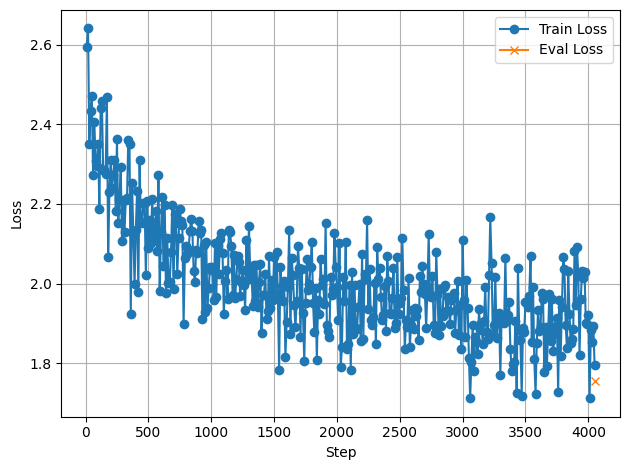

In [9]:
import json
import matplotlib.pyplot as plt

with open("/content/trainer_state_post.json") as f:
    history = json.load(f)["log_history"]

train_steps, train_losses, eval_steps, eval_losses = [], [], [], []
for x in history:
    if "loss" in x: train_steps.append(x["step"]); train_losses.append(x["loss"])
    if "eval_loss" in x: eval_steps.append(x["step"]); eval_losses.append(x["eval_loss"])

plt.plot(train_steps, train_losses, label="Train Loss", marker="o")
plt.plot(eval_steps, eval_losses, label="Eval Loss", marker="x")
plt.xlabel("Step"); plt.ylabel("Loss"); plt.legend(); plt.grid(); plt.tight_layout()
plt.savefig("/content/loss_plot.png")

In [10]:
trainer.save_model("./my_final_model")

In [10]:
!zip -r /content.zip /content/

from google.colab import files
files.download("/content.zip")

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.04.29/ (stored 0%)
  adding: content/.config/logs/2025.04.29/13.36.23.017909.log (deflated 86%)
  adding: content/.config/logs/2025.04.29/13.36.33.741756.log (deflated 57%)
  adding: content/.config/logs/2025.04.29/13.36.14.136794.log (deflated 58%)
  adding: content/.config/logs/2025.04.29/13.36.33.025879.log (deflated 57%)
  adding: content/.config/logs/2025.04.29/13.36.24.613327.log (deflated 58%)
  adding: content/.config/logs/2025.04.29/13.35.51.631004.log (deflated 92%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/hidden_gcloud_config_universe_de

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# !rm -rf /content/sample_data/

In [13]:
import torch
print("\nGenerating one example from validation set:")
sample = val_ds[0]["text"]
target = val_ds[0]["summary"]

inputs = tokenizer(sample, return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN).to(model.device)
model.eval()
with torch.no_grad():
    outputs = model.generate(**inputs, max_length=MAX_TGT_LEN)
prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("SOURCE:\n", sample[:500], "...\n")
print("REFERENCE SUMMARY:\n", target, "\n")
print("MODEL PREDICTION:\n", prediction)


Generating one example from validation set:
SOURCE:
 SECTION 1. Section 50843.5 of the Health and Safety Code 
is amended to read: 
50843.5. (a) Subject to the availability of funding, the 
department shall make matching grants available to cities, counties, 
city and counties, and charitable nonprofit organizations organized 
under Section 501(c)(3) of the Internal Revenue Code that have 
created and are operating or will operate housing trust funds. A 
city, county, city and county, or charitable nonprofit organization 
that has previously been  ...

REFERENCE SUMMARY:
 Existing law establishes the Local Housing Trust Fund Matching Grant Program for the purpose of supporting local housing trust funds dedicated to the creation or preservation of affordable housing. Existing law requires the Department of Housing and Community Development to make available the amount of $35,000,000 for the Local Housing Trust Fund Matching Grant Program, from the continuously appropriated Housing and 

In [7]:
test_tok = all_data["test"].map(preprocess, batched=True, remove_columns=cols, desc="Tokenise test")
test_metrics = trainer.evaluate(eval_dataset=test_tok)

Tokenise test:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


In [8]:
print(test_metrics)

{'eval_loss': 2.4625840187072754, 'eval_model_preparation_time': 0.006, 'eval_rouge1': 14.3797, 'eval_rouge2': 6.1513, 'eval_rougeL': 10.8231, 'eval_rougeLsum': 10.8052, 'eval_runtime': 711.859, 'eval_samples_per_second': 1.405, 'eval_steps_per_second': 0.235}
